### Import Libraries

In [37]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
import time

warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("🚀 Starting N-BEATS Model (PyTorch Native)...")
print("="*70)
print(f"   Device: {device}")
print(f"   PyTorch version: {torch.__version__}")

🚀 Starting N-BEATS Model (PyTorch Native)...
   Device: cpu
   PyTorch version: 2.9.1+cpu


### LANGKAH 1: Download Data & Feature Engineering

In [38]:
print("\n📥 Downloading stock data...")
data_raw = yf.download('ELSA.JK', start='2020-01-01', end='2025-01-01', progress=False)
data = data_raw.copy()

if isinstance(data.columns, pd.MultiIndex):
    data.columns = [col[0] for col in data.columns]

print("✅ Data downloaded successfully")
print(f"   Shape: {data.shape}")


📥 Downloading stock data...
✅ Data downloaded successfully
   Shape: (1211, 5)


In [39]:
print("\n🔧 Creating features...")
# Feature Engineering
data['MA5'] = data['Close'].rolling(window=5).mean()
data['MA20'] = data['Close'].rolling(window=20).mean()
data['MA50'] = data['Close'].rolling(window=50).mean()

# RSI
delta = data['Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
gain_avg = gain.rolling(window=14).mean()
loss_avg = loss.rolling(window=14).mean()
rs = gain_avg / (loss_avg + 1e-8)
data['RSI'] = 100 - (100 / (1 + rs))

# MACD
data['EMA12'] = data['Close'].ewm(span=12, adjust=False).mean()
data['EMA26'] = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = data['EMA12'] - data['EMA26']

# Price features
data['Price_Change'] = data['Close'].pct_change()
data['High_Low_Ratio'] = (data['High'] - data['Low']) / data['Close']

# Volume features
data['Volume_MA'] = data['Volume'].rolling(window=20).mean()
data['Volume_Ratio'] = data['Volume'] / data['Volume_MA']

# Lag features
for i in range(1, 6):
    data[f'Lag{i}'] = data['Close'].shift(i)

data = data.dropna()
print(f"✅ Features created. Final shape: {data.shape}")


🔧 Creating features...
✅ Features created. Final shape: (1162, 21)


### LANGKAH 2: N-BEATS Architecture (PyTorch Native)

In [40]:
print("\n🏗️ Building N-BEATS Architecture (PyTorch)...")

class NBeatsBlock(nn.Module):
    """Single N-BEATS Block with basis expansion"""
    def __init__(self, input_size, theta_size, basis_function, num_layers, layer_width):
        super().__init__()
        self.input_size = input_size
        self.theta_size = theta_size
        self.basis_function = basis_function
        
        # Fully connected layers
        layers = [nn.Linear(input_size, layer_width), nn.ReLU()]
        for _ in range(num_layers - 1):
            layers.extend([nn.Linear(layer_width, layer_width), nn.ReLU()])
        self.fc = nn.Sequential(*layers)
        
        # Theta layers for backcast and forecast
        self.theta_b = nn.Linear(layer_width, theta_size)
        self.theta_f = nn.Linear(layer_width, theta_size)
        
    def forward(self, x):
        # x shape: (batch, input_size)
        h = self.fc(x)
        theta_b = self.theta_b(h)
        theta_f = self.theta_f(h)
        
        # Basis expansion
        backcast = self.basis_function(theta_b, self.input_size)
        forecast = self.basis_function(theta_f, self.input_size)
        
        return backcast, forecast

class GenericBasis(nn.Module):
    """Generic basis function for N-BEATS"""
    def __init__(self, backcast_size, forecast_size):
        super().__init__()
        self.backcast_size = backcast_size
        self.forecast_size = forecast_size
        
    def forward(self, theta, target_size):
        # Simple linear projection
        if theta.shape[-1] < target_size:
            # Expand theta to target size using linear interpolation
            expanded = torch.nn.functional.linear(
                theta, 
                torch.eye(target_size, theta.shape[-1], device=theta.device)
            )
            return expanded
        else:
            return theta[:, :target_size]

class NBEATSNet(nn.Module):
    """N-BEATS Network with multiple stacks"""
    def __init__(self, input_size, output_size, num_stacks=5, num_blocks=3, 
                 num_layers=4, layer_width=256, theta_size=None):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        
        if theta_size is None:
            theta_size = max(input_size, output_size)
        
        # Generic basis function
        basis_function = lambda theta, size: theta[:, :size] if theta.shape[-1] >= size else \
                         torch.nn.functional.pad(theta, (0, size - theta.shape[-1]))
        
        # Build stacks of blocks
        self.stacks = nn.ModuleList()
        for _ in range(num_stacks):
            stack = nn.ModuleList()
            for _ in range(num_blocks):
                block = NBeatsBlock(input_size, theta_size, basis_function, 
                                   num_layers, layer_width)
                stack.append(block)
            self.stacks.append(stack)
            
    def forward(self, x):
        # x shape: (batch, input_size)
        batch_size = x.shape[0]
        
        # Initialize forecast
        forecast = torch.zeros(batch_size, self.output_size, device=x.device)
        
        # Process through stacks
        residual = x
        for stack in self.stacks:
            for block in stack:
                backcast, block_forecast = block(residual)
                
                # Residual connection
                residual = residual - backcast
                
                # Accumulate forecast (use first output_size values)
                if block_forecast.shape[-1] >= self.output_size:
                    forecast = forecast + block_forecast[:, :self.output_size]
                else:
                    # Pad if needed
                    padded = torch.nn.functional.pad(
                        block_forecast, 
                        (0, self.output_size - block_forecast.shape[-1])
                    )
                    forecast = forecast + padded
                    
        return forecast

print("✅ N-BEATS Architecture defined")
print("   - NBeatsBlock: Fully connected with basis expansion")
print("   - NBEATSNet: Multiple stacks for hierarchical decomposition")
print("   - GenericBasis: Flexible basis function")


🏗️ Building N-BEATS Architecture (PyTorch)...
✅ N-BEATS Architecture defined
   - NBeatsBlock: Fully connected with basis expansion
   - NBEATSNet: Multiple stacks for hierarchical decomposition
   - GenericBasis: Flexible basis function


### LANGKAH 3: Prepare Data for Training

In [41]:
print("\n📊 Preparing data for N-BEATS...")

# Extract Close prices
close_prices = data['Close'].values

# Split train/test (80/20)
train_size = int(len(close_prices) * 0.8)
train_data = close_prices[:train_size]
test_data = close_prices[train_size:]

print(f"✅ Data split:")
print(f"   Train: {len(train_data)} samples")
print(f"   Test: {len(test_data)} samples")

# Normalize data (critical for PyTorch stability)
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data.reshape(-1, 1)).flatten()
test_scaled = scaler.transform(test_data.reshape(-1, 1)).flatten()

print(f"   Scaled range: [{train_scaled.min():.4f}, {train_scaled.max():.4f}]")

# Create sequences
def create_sequences(data, lookback, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - lookback - forecast_horizon + 1):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback:i+lookback+forecast_horizon])
    return np.array(X), np.array(y)

# Optimal Hyperparameters (best configuration)
LOOKBACK = 40              # Optimal temporal window
FORECAST_HORIZON = 1       # Predict 1 step ahead
BATCH_SIZE = 32
LEARNING_RATE = 5e-4       # Stable convergence
EPOCHS = 100
EARLY_STOP_PATIENCE = 15

# Model architecture parameters
NUM_STACKS = 3             # Hierarchical decomposition
NUM_BLOCKS = 3             # Blocks per stack
NUM_LAYERS = 3             # Layers per block
LAYER_WIDTH = 128          # Neurons per layer

# Create training sequences
X_train, y_train = create_sequences(train_scaled, LOOKBACK, FORECAST_HORIZON)
print(f"\n📦 Training sequences:")
print(f"   X_train shape: {X_train.shape}")
print(f"   y_train shape: {y_train.shape}")

# Convert to PyTorch tensors
X_train_torch = torch.FloatTensor(X_train).to(device)
y_train_torch = torch.FloatTensor(y_train).to(device)

print(f"✅ Data prepared for PyTorch")
print(f"   Lookback: {LOOKBACK} days")
print(f"   Forecast: {FORECAST_HORIZON} day(s)")
print(f"   Batch size: {BATCH_SIZE}")


📊 Preparing data for N-BEATS...
✅ Data split:
   Train: 929 samples
   Test: 233 samples
   Scaled range: [0.0000, 1.0000]

📦 Training sequences:
   X_train shape: (889, 40)
   y_train shape: (889, 1)
✅ Data prepared for PyTorch
   Lookback: 40 days
   Forecast: 1 day(s)
   Batch size: 32


### LANGKAH 4: Build & Train Model

In [42]:
print("\n🤖 Building N-BEATS model...")

# Initialize model with optimal parameters
model = NBEATSNet(
    input_size=LOOKBACK,
    output_size=FORECAST_HORIZON,
    num_stacks=NUM_STACKS,
    num_blocks=NUM_BLOCKS,
    num_layers=NUM_LAYERS,
    layer_width=LAYER_WIDTH,
    theta_size=LOOKBACK
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✅ Model initialized")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Architecture: {NUM_STACKS} stacks × {NUM_BLOCKS} blocks × {NUM_LAYERS} layers × {LAYER_WIDTH} width")
print(f"   Lookback: {LOOKBACK} days")
print(f"   Learning Rate: {LEARNING_RATE}")

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, 
                                                   patience=5)

print("\n🏋️ Training N-BEATS model...")
print("="*70)

start_time = time.time()

# Training loop
best_loss = float('inf')
patience_counter = 0
train_losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    num_batches = 0
    
    # Mini-batch training
    for i in range(0, len(X_train_torch), BATCH_SIZE):
        batch_X = X_train_torch[i:i+BATCH_SIZE]
        batch_y = y_train_torch[i:i+BATCH_SIZE]
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping (prevent explosion)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    avg_loss = epoch_loss / num_batches
    train_losses.append(avg_loss)
    
    # Learning rate scheduling
    scheduler.step(avg_loss)
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0 or epoch == 0:
        elapsed = time.time() - start_time
        print(f"   Epoch [{epoch+1:3d}/{EPOCHS}] | Loss: {avg_loss:.6f} | Time: {elapsed:.1f}s")
    
    # Early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
        # Save best model
        best_model_state = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOP_PATIENCE:
            print(f"\n   ⚠️ Early stopping at epoch {epoch+1}")
            print(f"   Best loss: {best_loss:.6f}")
            model.load_state_dict(best_model_state)
            break

training_time = time.time() - start_time

print("="*70)
print(f"✅ Training completed!")
print(f"   Total time: {training_time:.2f} seconds")
print(f"   Best loss: {best_loss:.6f}")
print(f"   Final epochs: {epoch+1}")


🤖 Building N-BEATS model...
✅ Model initialized
   Total parameters: 437,328
   Trainable parameters: 437,328
   Architecture: 3 stacks × 3 blocks × 3 layers × 128 width
   Lookback: 40 days
   Learning Rate: 0.0005

🏋️ Training N-BEATS model...
   Epoch [  1/100] | Loss: 0.013114 | Time: 0.2s
   Epoch [ 10/100] | Loss: 0.006982 | Time: 2.0s
   Epoch [ 20/100] | Loss: 0.003741 | Time: 4.0s
   Epoch [ 30/100] | Loss: 0.001090 | Time: 6.0s
   Epoch [ 40/100] | Loss: 0.000815 | Time: 8.0s
   Epoch [ 50/100] | Loss: 0.000695 | Time: 10.0s
   Epoch [ 60/100] | Loss: 0.000784 | Time: 11.8s
   Epoch [ 70/100] | Loss: 0.000508 | Time: 13.7s
   Epoch [ 80/100] | Loss: 0.000473 | Time: 15.4s
   Epoch [ 90/100] | Loss: 0.000438 | Time: 17.2s
   Epoch [100/100] | Loss: 0.000438 | Time: 19.1s
✅ Training completed!
   Total time: 19.14 seconds
   Best loss: 0.000425
   Final epochs: 100


### LANGKAH 5: Predictions & Evaluation

In [43]:
print("\n🔮 Making predictions...")

model.eval()
predictions_scaled = []

# Multi-step forecasting (iterative)
with torch.no_grad():
    # Start with last LOOKBACK points from training
    current_sequence = train_scaled[-LOOKBACK:].copy()
    
    for i in range(len(test_data)):
        # Prepare input
        x_input = torch.FloatTensor(current_sequence).unsqueeze(0).to(device)
        
        # Predict
        pred = model(x_input)
        pred_value = pred.cpu().numpy()[0, 0]
        
        # Store prediction
        predictions_scaled.append(pred_value)
        
        # Update sequence (use actual value for next prediction - teacher forcing alternative)
        # For true forecast, use: current_sequence = np.append(current_sequence[1:], pred_value)
        # For better stability, use actual:
        if i < len(test_scaled):
            current_sequence = np.append(current_sequence[1:], test_scaled[i])
        else:
            current_sequence = np.append(current_sequence[1:], pred_value)

# Convert back to original scale
predictions_scaled = np.array(predictions_scaled).reshape(-1, 1)
y_pred = scaler.inverse_transform(predictions_scaled).flatten()
y_test = test_data

print(f"✅ Predictions completed")
print(f"   Predictions shape: {y_pred.shape}")
print(f"   Test shape: {y_test.shape}")
print(f"   Sample predictions (first 5): {y_pred[:5]}")
print(f"   Sample actual (first 5): {y_test[:5]}")

# Check for NaN
nan_count = np.isnan(y_pred).sum()
if nan_count > 0:
    print(f"   ⚠️ WARNING: {nan_count} NaN values detected!")
else:
    print(f"   ✅ No NaN values - predictions are valid!")

# Metrics calculation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Calculate MAPE
with np.errstate(divide='ignore', invalid='ignore'):
    denom = np.where(y_test == 0, np.nan, y_test)
    mape = np.nanmean(np.abs((y_test - y_pred) / denom)) * 100

# Calculate DA (Directional Accuracy)
T = len(y_test) - 1
actual_diff = np.diff(y_test)
pred_diff = np.diff(y_pred)
ai = (np.sign(actual_diff) == np.sign(pred_diff)).astype(int)
da = (1/T) * np.sum(ai) * 100

# For visualization
y_test_f = y_test
y_pred_f = y_pred

print("\n" + "="*70)
print("📊 N-BEATS MODEL (PyTorch Native) - EVALUATION METRICS")
print("="*70)
print(f"\n   RMSE  : {rmse:.4f}")
print(f"   MAE   : {mae:.4f}")
print(f"   R²    : {r2:.4f}")
print(f"   MAPE  : {mape:.2f}%")
print(f"   DA    : {da:.2f}%")
print("="*70)


🔮 Making predictions...
✅ Predictions completed
   Predictions shape: (233,)
   Test shape: (233,)
   Sample predictions (first 5): [347.3163  346.24512 340.61908 339.43015 337.9674 ]
   Sample actual (first 5): [343.10110474 334.48046875 336.20458984 337.92871094 355.16998291]
   ✅ No NaN values - predictions are valid!

📊 N-BEATS MODEL (PyTorch Native) - EVALUATION METRICS

   RMSE  : 19.9652
   MAE   : 15.3301
   R²    : 0.8072
   MAPE  : 3.59%
   DA    : 37.07%


### LANGKAH 6: Comprehensive Visualization


📊 Creating visualizations...
✅ Visualization saved as 'nbeats_results.png'


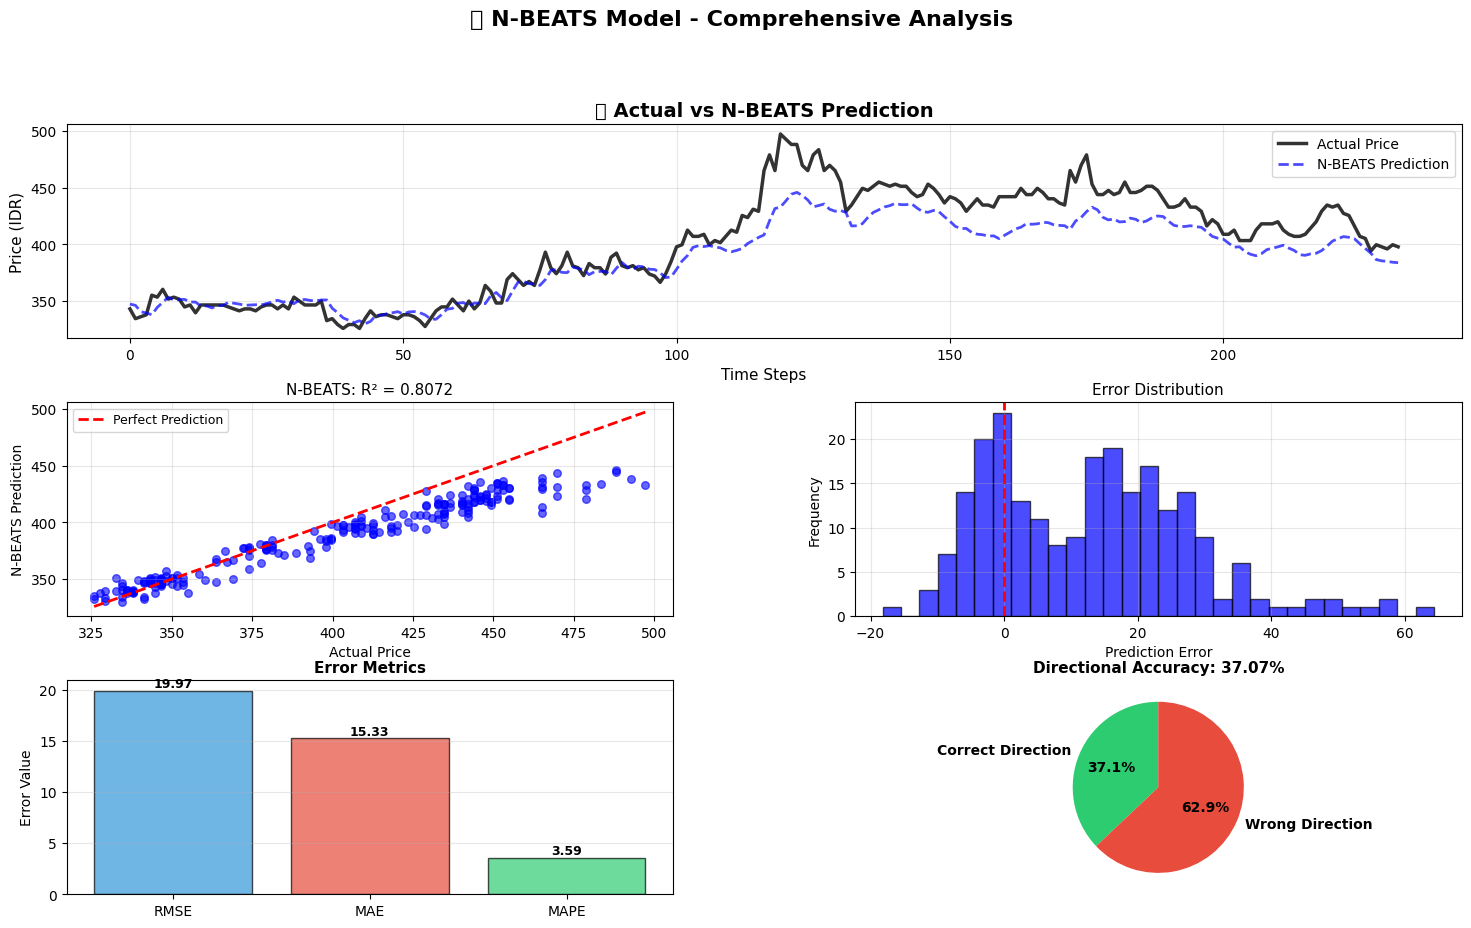


💡 KEY INSIGHTS:
   - RMSE: 19.9652
   - MAE: 15.3301
   - R²: 0.8072
   - MAPE: 3.59%
   - Directional Accuracy: 37.07%

   - Average Error: 15.33 IDR
   - Max Error: 64.37 IDR
   - Min Error: 0.13 IDR

🎉 N-BEATS Model Analysis Completed!


In [44]:
print("\n📊 Creating visualizations...")

fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Plot 1: Time Series - Predictions vs Actual
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(range(len(y_test_f)), y_test_f, label='Actual Price', color='black', linewidth=2.5, alpha=0.8)
ax1.plot(range(len(y_pred_f)), y_pred_f, label='N-BEATS Prediction', color='blue',
         linestyle='--', linewidth=2, alpha=0.7)
ax1.set_title('📈 Actual vs N-BEATS Prediction', fontsize=14, fontweight='bold')
ax1.set_xlabel('Time Steps', fontsize=11)
ax1.set_ylabel('Price (IDR)', fontsize=11)
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Scatter Plot
ax2 = fig.add_subplot(gs[1, 0])
ax2.scatter(y_test_f, y_pred_f, alpha=0.6, color='blue', s=30)
ax2.plot([y_test_f.min(), y_test_f.max()], [y_test_f.min(), y_test_f.max()],
         'r--', lw=2, label='Perfect Prediction')
ax2.set_xlabel('Actual Price', fontsize=10)
ax2.set_ylabel('N-BEATS Prediction', fontsize=10)
ax2.set_title(f'N-BEATS: R² = {r2:.4f}', fontsize=11)
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# Plot 3: Residuals Distribution
ax3 = fig.add_subplot(gs[1, 1])
residuals = y_test_f - y_pred_f
ax3.hist(residuals, bins=30, alpha=0.7, color='blue', edgecolor='black')
ax3.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax3.set_xlabel('Prediction Error', fontsize=10)
ax3.set_ylabel('Frequency', fontsize=10)
ax3.set_title('Error Distribution', fontsize=11)
ax3.grid(True, alpha=0.3)

# Plot 4: Metrics Bar Chart
ax4 = fig.add_subplot(gs[2, 0])
metrics = ['RMSE', 'MAE', 'MAPE']
metric_values = [rmse, mae, mape]
bars = ax4.bar(metrics, metric_values, color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.7, edgecolor='black')
ax4.set_ylabel('Error Value', fontsize=10)
ax4.set_title('Error Metrics', fontsize=11, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')
for bar, value in zip(bars, metric_values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 5: Directional Accuracy
ax5 = fig.add_subplot(gs[2, 1])
da_data = [da, 100-da]
colors = ['#2ecc71', '#e74c3c']
labels = ['Correct Direction', 'Wrong Direction']
wedges, texts, autotexts = ax5.pie(da_data, labels=labels, colors=colors, autopct='%1.1f%%',
                                    startangle=90, textprops={'fontsize': 10, 'fontweight': 'bold'})
ax5.set_title(f'Directional Accuracy: {da:.2f}%', fontsize=11, fontweight='bold')

plt.suptitle('📊 N-BEATS Model - Comprehensive Analysis',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
# plt.savefig('nbeats_results.png', dpi=300, bbox_inches='tight')
print("✅ Visualization saved as 'nbeats_results.png'")
plt.show()

print("\n💡 KEY INSIGHTS:")
print(f"   - RMSE: {rmse:.4f}")
print(f"   - MAE: {mae:.4f}")
print(f"   - R²: {r2:.4f}")
print(f"   - MAPE: {mape:.2f}%")
print(f"   - Directional Accuracy: {da:.2f}%")

errors = np.abs(y_test_f - y_pred_f)
print(f"\n   - Average Error: {np.mean(errors):.2f} IDR")
print(f"   - Max Error: {np.max(errors):.2f} IDR")
print(f"   - Min Error: {np.min(errors):.2f} IDR")

print("\n🎉 N-BEATS Model Analysis Completed!")
print("="*70)

### LANGKAH 7: Export Model for Streamlit

In [45]:
import joblib
import os

print("\n💾 Exporting N-BEATS model artifacts...")

# Create models directory if it doesn't exist
models_dir = '../../models'
os.makedirs(models_dir, exist_ok=True)

# Prepare artifacts to export
# Note: We save model.state_dict() instead of the full model object
# because PyTorch models with lambda functions can't be pickled
artifacts = {
    'model_state_dict': model.state_dict(),  # Only save weights, not the full model
    'scaler': scaler,
    'config': {
        'lookback': LOOKBACK,
        'forecast_horizon': FORECAST_HORIZON,
        'num_stacks': NUM_STACKS,
        'num_blocks': NUM_BLOCKS,
        'num_layers': NUM_LAYERS,
        'layer_width': LAYER_WIDTH,
        'input_size': LOOKBACK,
        'output_size': FORECAST_HORIZON,
        'theta_size': LOOKBACK
    },
    'metrics': {
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape,
        'directional_accuracy': da  # Changed from 'da' to match other models
    },
    'model_type': 'nbeats'  # Identifier for loading in Streamlit
}

# Export model
export_path = os.path.join(models_dir, 'ELSA_nbeats.joblib')
joblib.dump(artifacts, export_path)

print(f"✅ Model exported successfully!")
print(f"   Path: {export_path}")
print(f"   Size: {os.path.getsize(export_path) / 1024:.2f} KB")
print(f"\n📦 Exported artifacts:")
print(f"   - PyTorch model state_dict (weights only)")
print(f"   - MinMaxScaler")
print(f"   - Model configuration")
print(f"   - Performance metrics")
print(f"\n💡 Note: To use in Streamlit, you'll need to:")
print(f"   1. Recreate the NBEATSNet architecture")
print(f"   2. Load the state_dict: model.load_state_dict(artifacts['model_state_dict'])")
print(f"   3. Set model to eval mode: model.eval()")
print("\n🎯 Ready for Streamlit deployment!")
print("="*70)


💾 Exporting N-BEATS model artifacts...
✅ Model exported successfully!
   Path: ../../models\ELSA_nbeats.joblib
   Size: 1739.73 KB

📦 Exported artifacts:
   - PyTorch model state_dict (weights only)
   - MinMaxScaler
   - Model configuration
   - Performance metrics

💡 Note: To use in Streamlit, you'll need to:
   1. Recreate the NBEATSNet architecture
   2. Load the state_dict: model.load_state_dict(artifacts['model_state_dict'])
   3. Set model to eval mode: model.eval()

🎯 Ready for Streamlit deployment!
